## Сверточные сети: CIFAR-10
(*Перед выполнением, прочти задание до конца*)

---

Создайте функцию **get_img_object_name**(*filename*), входным параметром которой является имя файла-изображения и которая возвращает название объекта (*англ.*), представленного на изображении. А так же, с её помощью, заполните проверочный CSV-файл

Возможные объекты: *airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck*

Для опредления объекта на изображении используйте свёрточную сеть, обучать которую необходимо на датасете [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html). Обучающие и проверочные данные датасета расположены в каталогах */opt/datasets/CIFAR-10/train* и */opt/datasets/CIFAR-10/test* (см. код в следющих ячейках)

Изучить датасет CIFAR-10 можно открыв в проводнике: Сеть -> RIG -> Datasets -> CIFAR-10

In [1]:
# Используем GPU 0
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# Отключаем отладочные сообщения в TensorFlow
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "2"

Каталоги датасета (*используй эти переменные*)

In [2]:
TRAIN_DIR = '/opt/datasets/CIFAR-10/train'
TEST_DIR = '/opt/datasets/CIFAR-10/test'

In [3]:
IMG_SIZE = (32, 32)
BATCH_SIZE = 64

Создание и обучение нейросети (*можно и нужно драть код с предыдущих занятий, учитывая специфику датасета CIFAR-10*)

In [4]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(data_format="channels_last")

gen_args = {
    'target_size': IMG_SIZE,
    'color_mode': 'rgb',
    'class_mode': 'categorical',
    'batch_size': BATCH_SIZE,
}

train_gen = gen.flow_from_directory(directory=TRAIN_DIR, shuffle=True, **gen_args)
val_gen = gen.flow_from_directory(directory=TEST_DIR, shuffle=False, **gen_args)

Found 50000 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
model = tf.keras.Sequential(name = 'Conv')

model.add(tf.keras.layers.InputLayer(input_shape = IMG_SIZE + (3,) ))
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.GlobalAveragePooling2D())
#model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.summary()

Model: "Conv"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 10)                5770   

In [6]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = ['accuracy'],
)

In [7]:
res = model.fit(
    x = train_gen,
    batch_size = BATCH_SIZE,
    epochs = 15,
    validation_data = val_gen,
)

Epoch 1/15
782/782 [==============================] - 197s 238ms/step - loss: 2.9831 - accuracy: 0.1039 - val_loss: 2.3025 - val_accuracy: 0.1048
Epoch 2/15
782/782 [==============================] - 17s 22ms/step - loss: 2.2962 - accuracy: 0.1094 - val_loss: 2.3009 - val_accuracy: 0.1061
Epoch 3/15
782/782 [==============================] - 17s 22ms/step - loss: 2.1466 - accuracy: 0.2102 - val_loss: 2.0130 - val_accuracy: 0.2668
Epoch 4/15
782/782 [==============================] - 17s 22ms/step - loss: 1.8033 - accuracy: 0.3340 - val_loss: 1.6952 - val_accuracy: 0.3861
Epoch 5/15
782/782 [==============================] - 17s 22ms/step - loss: 1.6320 - accuracy: 0.4131 - val_loss: 1.5869 - val_accuracy: 0.4284
Epoch 6/15
782/782 [==============================] - 17s 22ms/step - loss: 1.5480 - accuracy: 0.4479 - val_loss: 1.5330 - val_accuracy: 0.4491
Epoch 7/15
782/782 [==============================] - 17s 22ms/step - loss: 1.4919 - accuracy: 0.4669 - val_loss: 1.5082 - val_accurac

Функция **get_img_object_name()**

In [8]:
from PIL import Image, ImageOps
import numpy as np
def get_img_object_name(filename):
    # Читаем файл
    img = Image.open(filename)
    # Ресайзим изображение до размера с которым умеет работать сеть
    img = img.resize(IMG_SIZE)
    # Представляем изображение как массив NumPy
    data = np.asarray(img)
    # Так как изображение grayscale, у него нет измерения для каналов цвета, так что добавляем новое измерение и shape меняется
    # (Height, With) -> (Height, With, 1)
    data = data[..., np.newaxis]
    # Inference модель, предварительно добавив измерение для batch-ей
    data_pred = model.predict(data[np.newaxis, ...])
    # Нам вернулись вероятности каждого класса, выбираем класс (точнее его номер) с максимальной вероятностью
    a = np.argmax(data_pred[0])
    # Получаем из генератора список классов
    classes = list(train_gen.class_indices.keys())
    # Из списка слкассов выбираем нужный
    b = classes[a]
    return b

In [9]:
img = Image.open("/opt/datasets/CIFAR-10/examination/cat.jpg")
img = img.resize(IMG_SIZE)
data = np.asarray(img)
data = data[..., np.newaxis]
data_pred = model.predict(data[np.newaxis, ...])
a = np.argmax(data_pred[0])
print(a)
classes = list(train_gen.class_indices.keys())
print (classes)
b = classes[a]
b

5
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


'dog'

---
Оценить работу функции можно следующим кодом:

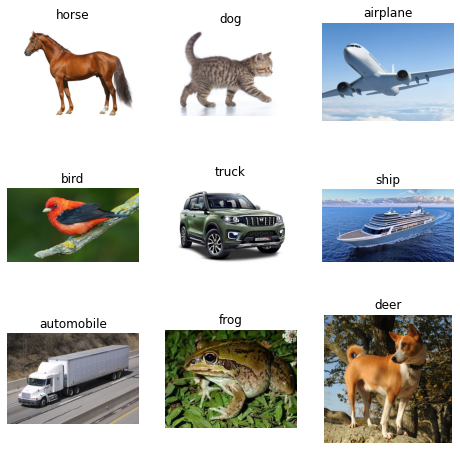

In [10]:
import matplotlib.pyplot as plt
from PIL import Image
import glob

files = glob.glob("/opt/datasets/CIFAR-10/examination/*.jpg")

fig, axs = plt.subplots(3, 3, figsize = (8, 8))
for (fn, ax) in zip(files, axs.flatten()):
    img = Image.open(fn)
    ax.imshow(img)
    ax.set_title(get_img_object_name(fn))
    ax.axis('off')

---

## Проверка

Файл **07-CIFAR-example.csv** содержит 2 столбца: *filename* и *object*. В столбце *filename* - имена файлов-изображений для определения объектов на них, а столбец *object* - пустой.

Необходимо заполнить столбец *object*, указав название объекта, изображенного на картинке и сохранить эти данные в файл **07-CIFAR-submission.csv**

In [11]:
import pandas as pd
df = pd.read_csv('07-CIFAR-Example.csv', sep="\t")
df

,filename,object
0,/opt/datasets/CIFAR-10/examination/horse.jpg,NaN
1,/opt/datasets/CIFAR-10/examination/cat.jpg,NaN
2,/opt/datasets/CIFAR-10/examination/airplane.jpg,NaN
3,/opt/datasets/CIFAR-10/examination/bird.jpg,NaN
4,/opt/datasets/CIFAR-10/examination/automobile.jpg,NaN
5,/opt/datasets/CIFAR-10/examination/ship.jpg,NaN
6,/opt/datasets/CIFAR-10/examination/truck.jpg,NaN
7,/opt/datasets/CIFAR-10/examination/frog.jpg,NaN
8,/opt/datasets/CIFAR-10/examination/dog.jpg,NaN


In [12]:
fns = list(df['filename'])
fns

['/opt/datasets/CIFAR-10/examination/horse.jpg',
 '/opt/datasets/CIFAR-10/examination/cat.jpg',
 '/opt/datasets/CIFAR-10/examination/airplane.jpg',
 '/opt/datasets/CIFAR-10/examination/bird.jpg',
 '/opt/datasets/CIFAR-10/examination/automobile.jpg',
 '/opt/datasets/CIFAR-10/examination/ship.jpg',
 '/opt/datasets/CIFAR-10/examination/truck.jpg',
 '/opt/datasets/CIFAR-10/examination/frog.jpg',
 '/opt/datasets/CIFAR-10/examination/dog.jpg']

In [13]:
result = []

for fn in fns:
    on = get_img_object_name(fn)
    result.append(on)
    #print('{} -> {}'.format(fn, on))
    
result

['horse',
 'dog',
 'airplane',
 'bird',
 'truck',
 'ship',
 'automobile',
 'frog',
 'deer']

In [14]:
df['object'] = result
df

,filename,object
0,/opt/datasets/CIFAR-10/examination/horse.jpg,horse
1,/opt/datasets/CIFAR-10/examination/cat.jpg,dog
2,/opt/datasets/CIFAR-10/examination/airplane.jpg,airplane
3,/opt/datasets/CIFAR-10/examination/bird.jpg,bird
4,/opt/datasets/CIFAR-10/examination/automobile.jpg,truck
5,/opt/datasets/CIFAR-10/examination/ship.jpg,ship
6,/opt/datasets/CIFAR-10/examination/truck.jpg,automobile
7,/opt/datasets/CIFAR-10/examination/frog.jpg,frog
8,/opt/datasets/CIFAR-10/examination/dog.jpg,deer


In [15]:
df.to_csv('07-CIFAR-submission.csv', sep="\t", index=False)